Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

# specific package for visualization
!pip install livelossplot --quiet
from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [ ]:
# normal data
X_test, y_test, person_train_valid, X_train_valid, y_train_valid, person_test = import_data()


# Conv1, trialsize 1000 (base case)

-- Fold [1/5] --
Epoch [10], Training loss [1.0681], Training accuracy [54.26%]
Epoch [10], Validation loss [1.1646], Validation accuracy [49.65%]
Epoch [20], Training loss [0.7954], Training accuracy [68.79%]
Epoch [20], Validation loss [1.0106], Validation accuracy [58.87%]
Epoch [30], Training loss [0.5955], Training accuracy [77.90%]
Epoch [30], Validation loss [0.9387], Validation accuracy [62.88%]
Epoch [40], Training loss [0.4225], Training accuracy [85.17%]
Epoch [40], Validation loss [0.9174], Validation accuracy [64.78%]
Epoch [50], Training loss [0.2874], Training accuracy [89.48%]
Epoch [50], Validation loss [0.9598], Validation accuracy [63.59%]
Epoch [60], Training loss [0.1986], Training accuracy [93.38%]
Epoch [60], Validation loss [0.9544], Validation accuracy [65.96%]
Epoch [70], Training loss [0.1615], Training accuracy [94.98%]
Epoch [70], Validation loss [0.9734], Validation accuracy [64.07%]
Epoch [80], Training loss [0.1285], Training accuracy [95.69%]
Epoch [80]

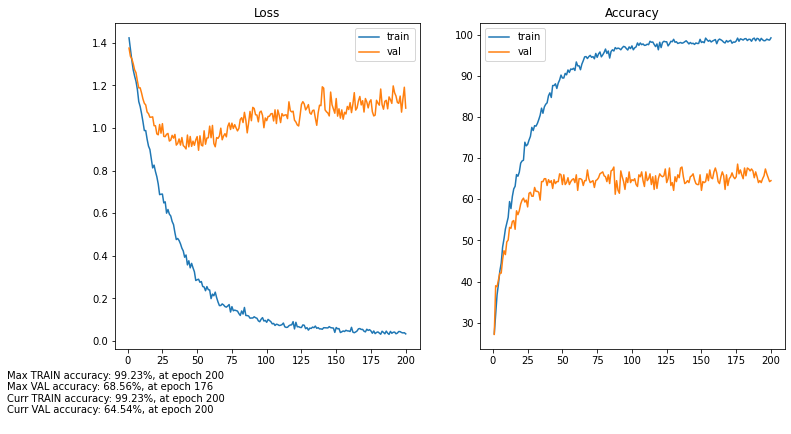

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 100
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.3, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv1, trialsize 500, stride 500

-- Fold [1/5] --
Epoch [10], Training loss [1.3230], Training accuracy [36.97%]
Epoch [10], Validation loss [1.3420], Validation accuracy [34.40%]
Epoch [20], Training loss [1.2183], Training accuracy [44.12%]
Epoch [20], Validation loss [1.2820], Validation accuracy [39.95%]
Epoch [30], Training loss [1.1120], Training accuracy [50.86%]
Epoch [30], Validation loss [1.2330], Validation accuracy [42.43%]
Epoch [40], Training loss [1.0254], Training accuracy [56.44%]
Epoch [40], Validation loss [1.2179], Validation accuracy [47.52%]
Epoch [50], Training loss [0.9120], Training accuracy [62.20%]
Epoch [50], Validation loss [1.1935], Validation accuracy [48.70%]
Epoch [60], Training loss [0.8277], Training accuracy [65.90%]
Epoch [60], Validation loss [1.2370], Validation accuracy [47.87%]
Epoch [70], Training loss [0.7077], Training accuracy [72.34%]
Epoch [70], Validation loss [1.2238], Validation accuracy [51.06%]
Epoch [80], Training loss [0.6075], Training accuracy [77.01%]
Epoch [80]

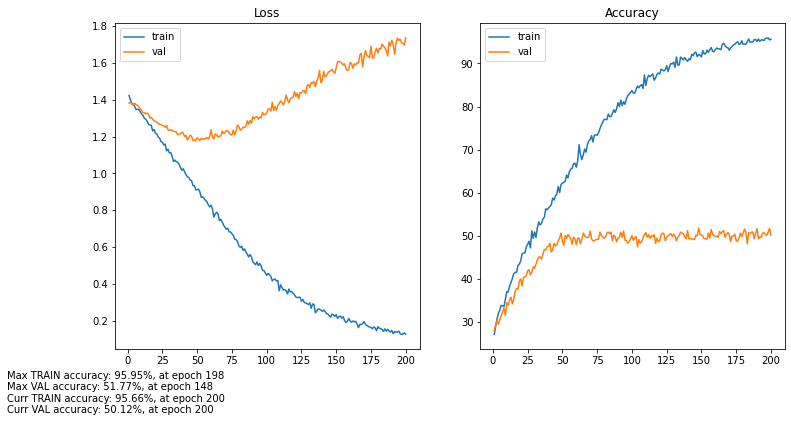

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 500
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.3, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv1, trialsize 500, stride 250

-- Fold [1/5] --
Epoch [10], Training loss [1.3369], Training accuracy [35.28%]
Epoch [10], Validation loss [1.3827], Validation accuracy [30.97%]
Epoch [20], Training loss [1.2514], Training accuracy [42.20%]
Epoch [20], Validation loss [1.3270], Validation accuracy [38.53%]
Epoch [30], Training loss [1.1379], Training accuracy [51.14%]
Epoch [30], Validation loss [1.2199], Validation accuracy [44.60%]
Epoch [40], Training loss [1.0296], Training accuracy [55.58%]
Epoch [40], Validation loss [1.1621], Validation accuracy [49.41%]
Epoch [50], Training loss [0.9334], Training accuracy [60.95%]
Epoch [50], Validation loss [1.1177], Validation accuracy [52.09%]
Epoch [60], Training loss [0.8465], Training accuracy [65.19%]
Epoch [60], Validation loss [1.1129], Validation accuracy [52.88%]
Epoch [70], Training loss [0.7567], Training accuracy [70.23%]
Epoch [70], Validation loss [1.0954], Validation accuracy [54.61%]
Epoch [80], Training loss [0.6614], Training accuracy [74.51%]
Epoch [80]

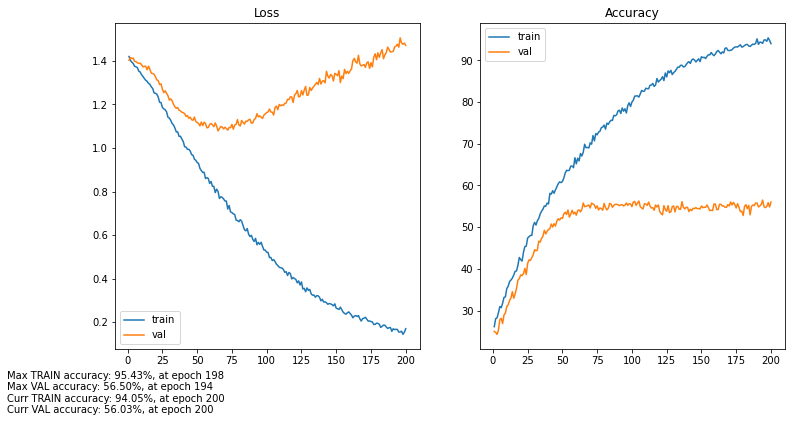

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 250
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.3, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv1, trialsize 500, stride 100

-- Fold [1/5] --
Epoch [10], Training loss [1.3240], Training accuracy [35.15%]
Epoch [10], Validation loss [1.3317], Validation accuracy [35.86%]
Epoch [20], Training loss [1.1788], Training accuracy [48.13%]
Epoch [20], Validation loss [1.1948], Validation accuracy [47.36%]
Epoch [30], Training loss [1.0642], Training accuracy [54.27%]
Epoch [30], Validation loss [1.1352], Validation accuracy [50.20%]
Epoch [40], Training loss [0.9673], Training accuracy [59.60%]
Epoch [40], Validation loss [1.1037], Validation accuracy [52.99%]
Epoch [50], Training loss [0.8960], Training accuracy [63.13%]
Epoch [50], Validation loss [1.0621], Validation accuracy [53.82%]
Epoch [60], Training loss [0.8370], Training accuracy [66.31%]
Epoch [60], Validation loss [1.0732], Validation accuracy [53.86%]
Epoch [70], Training loss [0.7745], Training accuracy [68.70%]
Epoch [70], Validation loss [1.0275], Validation accuracy [55.91%]
Epoch [80], Training loss [0.7078], Training accuracy [71.38%]
Epoch [80]

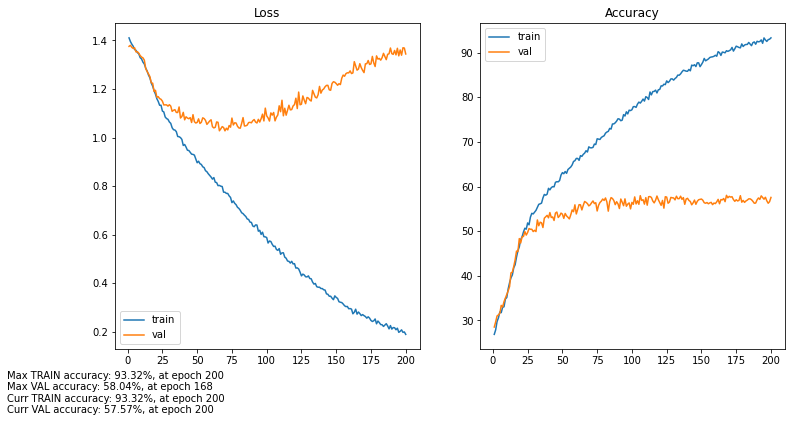

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 100
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.3, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv1, trialsize 500, stride 50

-- Fold [1/5] --
Epoch [10], Training loss [1.2614], Training accuracy [40.86%]
Epoch [10], Validation loss [1.2870], Validation accuracy [41.26%]
Epoch [20], Training loss [1.0878], Training accuracy [52.40%]
Epoch [20], Validation loss [1.1198], Validation accuracy [52.48%]
Epoch [30], Training loss [0.9913], Training accuracy [57.81%]
Epoch [30], Validation loss [1.0505], Validation accuracy [55.86%]
Epoch [40], Training loss [0.9055], Training accuracy [61.71%]
Epoch [40], Validation loss [1.0140], Validation accuracy [57.73%]
Epoch [50], Training loss [0.8301], Training accuracy [65.64%]
Epoch [50], Validation loss [1.0054], Validation accuracy [58.95%]
Epoch [60], Training loss [0.7614], Training accuracy [68.94%]
Epoch [60], Validation loss [0.9789], Validation accuracy [60.80%]
Epoch [70], Training loss [0.7006], Training accuracy [71.68%]
Epoch [70], Validation loss [0.9870], Validation accuracy [60.82%]
Epoch [80], Training loss [0.6444], Training accuracy [74.39%]
Epoch [80]

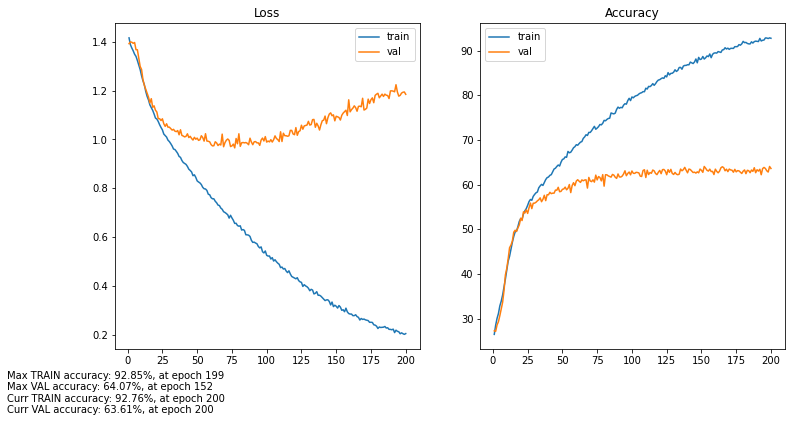

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 50
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.3, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 1000 (base case)

-- Fold [1/5] --
Epoch [10], Training loss [1.3715], Training accuracy [30.50%]
Epoch [10], Validation loss [1.3914], Validation accuracy [28.84%]
Epoch [20], Training loss [1.3066], Training accuracy [36.47%]
Epoch [20], Validation loss [1.3609], Validation accuracy [33.81%]
Epoch [30], Training loss [1.2371], Training accuracy [43.20%]
Epoch [30], Validation loss [1.3301], Validation accuracy [35.93%]
Epoch [40], Training loss [1.1649], Training accuracy [47.16%]
Epoch [40], Validation loss [1.2651], Validation accuracy [39.95%]
Epoch [50], Training loss [1.0592], Training accuracy [54.31%]
Epoch [50], Validation loss [1.1645], Validation accuracy [47.04%]
Epoch [60], Training loss [0.9508], Training accuracy [60.82%]
Epoch [60], Validation loss [1.0919], Validation accuracy [50.59%]
Epoch [70], Training loss [0.9020], Training accuracy [63.53%]
Epoch [70], Validation loss [1.0598], Validation accuracy [54.37%]
Epoch [80], Training loss [0.8382], Training accuracy [65.78%]
Epoch [80]

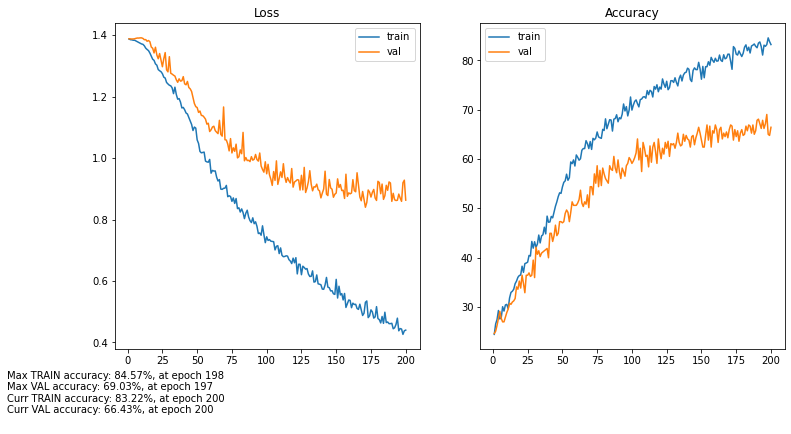

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 100
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.3).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

-- Fold [1/5] --
Epoch [10], Training loss [1.2863], Training accuracy [39.94%]
Epoch [10], Validation loss [1.3292], Validation accuracy [36.86%]
Epoch [20], Training loss [1.1034], Training accuracy [52.75%]
Epoch [20], Validation loss [1.1830], Validation accuracy [47.17%]
Epoch [30], Training loss [0.9930], Training accuracy [58.32%]
Epoch [30], Validation loss [1.1362], Validation accuracy [49.97%]
Epoch [40], Training loss [0.9057], Training accuracy [62.55%]
Epoch [40], Validation loss [1.1006], Validation accuracy [52.96%]
Epoch [50], Training loss [0.8352], Training accuracy [65.60%]
Epoch [50], Validation loss [1.0657], Validation accuracy [54.76%]
Epoch [60], Training loss [0.7716], Training accuracy [68.45%]
Epoch [60], Validation loss [1.0436], Validation accuracy [55.79%]
Epoch [70], Training loss [0.6997], Training accuracy [71.64%]
Epoch [70], Validation loss [1.0346], Validation accuracy [57.55%]
Epoch [80], Training loss [0.6383], Training accuracy [74.45%]
Epoch [80]

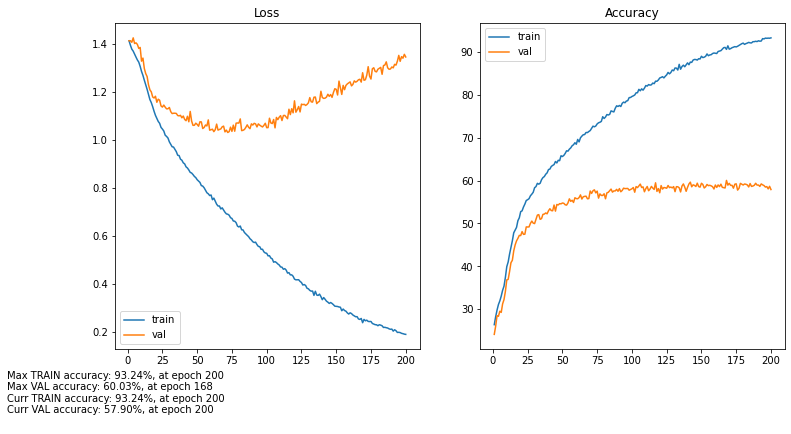

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 50
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.3, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv2, trialsize 500, stride 500

-- Fold [1/5] --
Epoch [10], Training loss [1.3436], Training accuracy [34.40%]
Epoch [10], Validation loss [1.3357], Validation accuracy [35.58%]
Epoch [20], Training loss [1.2853], Training accuracy [39.54%]
Epoch [20], Validation loss [1.2681], Validation accuracy [42.79%]
Epoch [30], Training loss [1.2136], Training accuracy [45.92%]
Epoch [30], Validation loss [1.2181], Validation accuracy [44.68%]
Epoch [40], Training loss [1.1652], Training accuracy [48.11%]
Epoch [40], Validation loss [1.1704], Validation accuracy [47.40%]
Epoch [50], Training loss [1.1078], Training accuracy [52.25%]
Epoch [50], Validation loss [1.1331], Validation accuracy [49.76%]
Epoch [60], Training loss [1.0791], Training accuracy [54.26%]
Epoch [60], Validation loss [1.1108], Validation accuracy [51.06%]
Epoch [70], Training loss [1.0444], Training accuracy [55.20%]
Epoch [70], Validation loss [1.0925], Validation accuracy [50.35%]
Epoch [80], Training loss [1.0067], Training accuracy [57.51%]
Epoch [80]

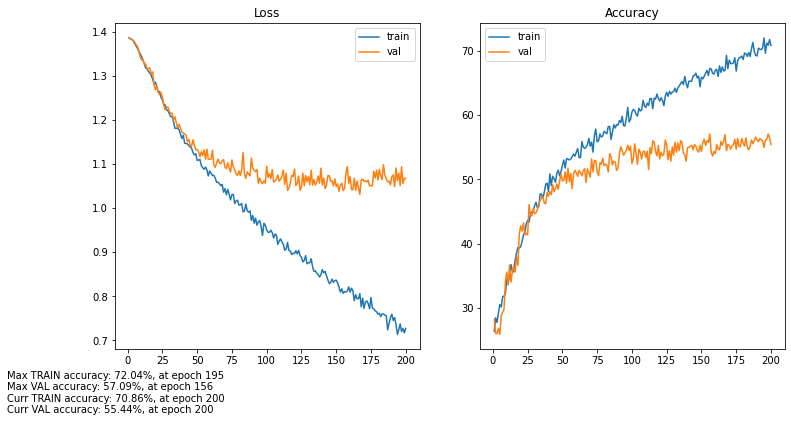

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 500
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.3).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv2, trialsize 500, stride 250

-- Fold [1/5] --
Epoch [10], Training loss [1.3304], Training accuracy [35.32%]
Epoch [10], Validation loss [1.3456], Validation accuracy [34.28%]
Epoch [20], Training loss [1.2370], Training accuracy [44.27%]
Epoch [20], Validation loss [1.2575], Validation accuracy [42.00%]
Epoch [30], Training loss [1.1530], Training accuracy [49.78%]
Epoch [30], Validation loss [1.1648], Validation accuracy [49.17%]
Epoch [40], Training loss [1.0929], Training accuracy [53.19%]
Epoch [40], Validation loss [1.1519], Validation accuracy [51.38%]
Epoch [50], Training loss [1.0572], Training accuracy [55.04%]
Epoch [50], Validation loss [1.1086], Validation accuracy [54.61%]
Epoch [60], Training loss [1.0090], Training accuracy [57.39%]
Epoch [60], Validation loss [1.0837], Validation accuracy [54.29%]
Epoch [70], Training loss [0.9884], Training accuracy [58.61%]
Epoch [70], Validation loss [1.0822], Validation accuracy [55.16%]
Epoch [80], Training loss [0.9444], Training accuracy [61.27%]
Epoch [80]

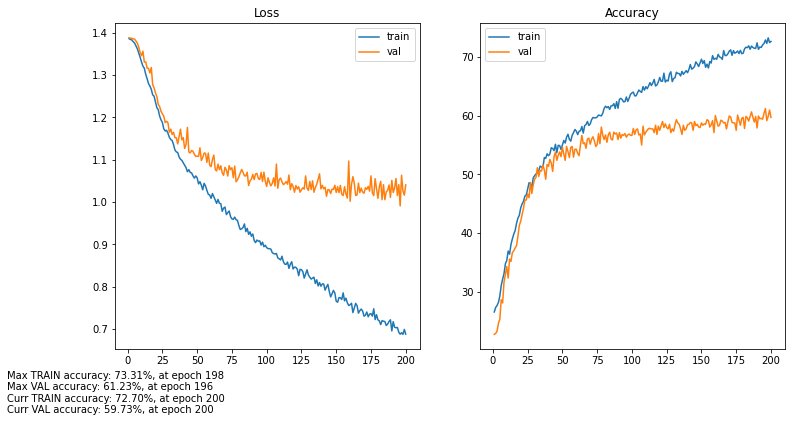

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 250
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.3).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv2, trialsize 500, stride 100

-- Fold [1/5] --
Epoch [10], Training loss [1.2766], Training accuracy [40.74%]
Epoch [10], Validation loss [1.2849], Validation accuracy [39.76%]
Epoch [20], Training loss [1.1334], Training accuracy [50.57%]
Epoch [20], Validation loss [1.1832], Validation accuracy [46.77%]
Epoch [30], Training loss [1.0573], Training accuracy [55.37%]
Epoch [30], Validation loss [1.1297], Validation accuracy [50.47%]
Epoch [40], Training loss [0.9890], Training accuracy [58.95%]
Epoch [40], Validation loss [1.1475], Validation accuracy [48.42%]
Epoch [50], Training loss [0.9455], Training accuracy [60.76%]
Epoch [50], Validation loss [1.1233], Validation accuracy [50.87%]
Epoch [60], Training loss [0.8996], Training accuracy [63.09%]
Epoch [60], Validation loss [1.0512], Validation accuracy [54.33%]
Epoch [70], Training loss [0.8598], Training accuracy [65.10%]
Epoch [70], Validation loss [1.0516], Validation accuracy [55.00%]
Epoch [80], Training loss [0.8224], Training accuracy [66.84%]
Epoch [80]

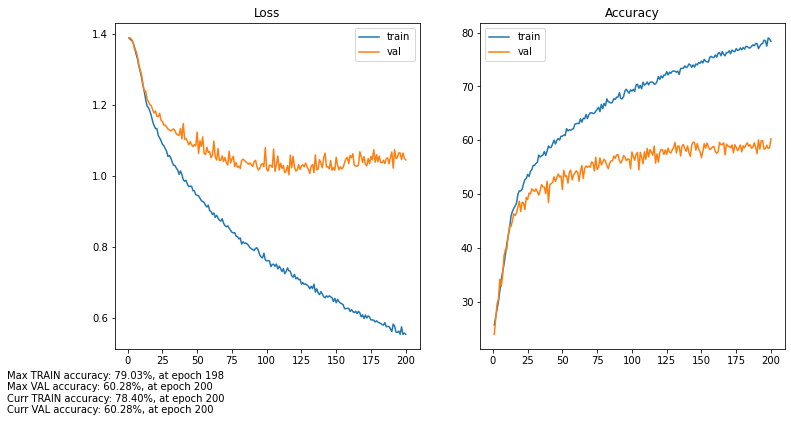

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 100
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.3).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# Conv2, trialsize 500, stride 50

-- Fold [1/5] --
Epoch [10], Training loss [1.2335], Training accuracy [43.89%]
Epoch [10], Validation loss [1.2307], Validation accuracy [44.32%]
Epoch [20], Training loss [1.0657], Training accuracy [54.29%]
Epoch [20], Validation loss [1.1064], Validation accuracy [52.10%]
Epoch [30], Training loss [0.9748], Training accuracy [59.33%]
Epoch [30], Validation loss [1.0449], Validation accuracy [55.68%]
Epoch [40], Training loss [0.8990], Training accuracy [62.71%]
Epoch [40], Validation loss [1.0503], Validation accuracy [55.92%]
Epoch [50], Training loss [0.8386], Training accuracy [66.04%]
Epoch [50], Validation loss [1.0292], Validation accuracy [57.23%]
Epoch [60], Training loss [0.7928], Training accuracy [68.01%]
Epoch [60], Validation loss [1.0079], Validation accuracy [57.83%]
Epoch [70], Training loss [0.7509], Training accuracy [70.17%]
Epoch [70], Validation loss [1.0404], Validation accuracy [56.26%]
Epoch [80], Training loss [0.7105], Training accuracy [72.23%]
Epoch [80]

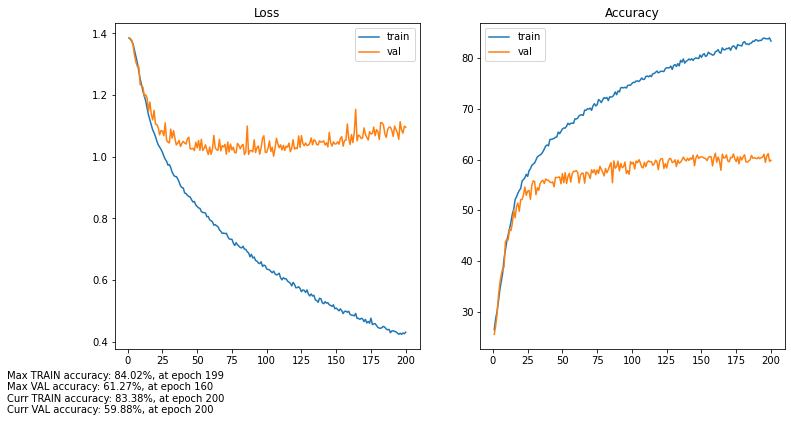

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 50
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.3).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))
